In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize
import timm
from torchmetrics.segmentation import DiceScore
from torchmetrics import JaccardIndex

import os
import glob
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib.colors import ListedColormap
import pandas as pd
from collections import OrderedDict

print(f"PyTorch version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.6.0+cu124
Using device: cuda


# Helper Function

In [2]:
def set_bn_eval(module):
    if isinstance(module, nn.BatchNorm2d):
        module.eval()

# LLEM and AFM

In [3]:
class CSDN_Tem(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(CSDN_Tem, self).__init__()
        self.depth_conv = nn.Conv2d(in_channels=in_ch, out_channels=in_ch, kernel_size=3, stride=1, padding=1, groups=in_ch)
        self.point_conv = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=1, stride=1, padding=0, groups=1)
    def forward(self, input):
        return self.point_conv(self.depth_conv(input))

class EnhanceNet(nn.Module):
    def __init__(self):
        super(EnhanceNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        number_f = 32
        self.e_conv1 = CSDN_Tem(3, number_f)
        self.e_conv2 = CSDN_Tem(number_f, number_f)
        self.e_conv3 = CSDN_Tem(number_f, number_f)
        self.e_conv4 = CSDN_Tem(number_f, number_f)
        self.e_conv5 = CSDN_Tem(number_f * 2, number_f)
        self.e_conv6 = CSDN_Tem(number_f * 2, number_f)
        self.e_conv7 = CSDN_Tem(number_f * 2, 3)
    def forward(self, x):
        x1 = self.relu(self.e_conv1(x))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))
        x5 = self.relu(self.e_conv5(torch.cat([x3, x4], 1)))
        x6 = self.relu(self.e_conv6(torch.cat([x2, x5], 1)))
        x_r = torch.tanh(self.e_conv7(torch.cat([x1, x6], 1)))
        return x1, x_r

In [4]:
# --- Attention Fusion Module ---
class AFM(nn.Module):
    def __init__(self, in_channels_llem, in_channels_seg):
        super(AFM, self).__init__()
        self.conv_llem = nn.Conv2d(in_channels_llem, in_channels_seg, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.channel_attention = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(in_channels_seg, in_channels_seg // 16, 1, bias=False), nn.ReLU(inplace=True), nn.Conv2d(in_channels_seg // 16, in_channels_seg, 1, bias=False), nn.Sigmoid())
    def forward(self, llem_features, seg_features):
        llem_features = self.conv_llem(llem_features)
        fused_features = self.relu(llem_features + seg_features)
        attention = self.channel_attention(fused_features)
        return fused_features * attention

# Deeplabv3+

In [5]:
class ECALayer(nn.Module):
    def __init__(self, channel, k_size=3):
        super(ECALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        y = self.global_avgpool(x)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y

class CBAMLayer(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAMLayer, self).__init__()
        self.channel_attention = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False), nn.ReLU(inplace=True), nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False), nn.Sigmoid())
        self.spatial_attention = nn.Sequential(nn.Conv2d(2, 1, 7, padding=3, bias=False), nn.Sigmoid())
    def forward(self, x):
        ca = self.channel_attention(x); x = x * ca
        sa_input = torch.cat([torch.mean(x, dim=1, keepdim=True), torch.max(x, dim=1, keepdim=True)[0]], dim=1); sa = self.spatial_attention(sa_input); x = x * sa
        return x

class FCALayer(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(FCALayer, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        y = self.global_avg_pool(x); y = self.fc1(y); y = self.relu(y); y = self.fc2(y); y = self.sigmoid(y)
        return x * y

# --- Backbone dan Modul DeepLabV3+ (Sesuai dengan Notebook Training Anda) ---
class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet18Backbone, self).__init__()
        self.resnet18 = timm.create_model('resnet18', pretrained=pretrained, features_only=True, out_indices=(0, 1, 2, 3))
        self.resnet18.apply(set_bn_eval)
        self.eca = ECALayer(channel=256, k_size=3)
        self.se = SEBlock(in_channels=256)
        self.cbam = CBAMLayer(in_channels=256)
    def forward(self, x):
        features = self.resnet18(x)
        low_level_feature = features[1]
        high_level_feature = self.eca(features[-1])
        high_level_feature = self.se(high_level_feature)
        high_level_feature = self.cbam(high_level_feature)
        return {'low_level': low_level_feature, 'out': high_level_feature, 'features': features}

class AtrousSeparableConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True):
        super(AtrousSeparableConvolution, self).__init__()
        self.body = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias, groups=in_channels), nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=bias))
    def forward(self, x):
        return self.body(x)

class ASPPPooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        size = x.shape[-2:]; x = self.avg_pool(x); x = self.conv(x)
        if x.shape[-1] > 1 and x.shape[-2] > 1: x = self.bn(x)
        x = self.relu(x); return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super(ASPP, self).__init__()
        modules = [nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True))]
        for rate in atrous_rates: modules.append(AtrousSeparableConvolution(in_channels, out_channels, kernel_size=3, padding=rate, dilation=rate, bias=False))
        modules.append(ASPPPooling(in_channels, out_channels)); self.convs = nn.ModuleList(modules)
        self.project = nn.Sequential(nn.Conv2d(len(modules) * out_channels, out_channels, 1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True), nn.Dropout(0.1))
    def forward(self, x):
        res = [conv(x) for conv in self.convs]; res = torch.cat(res, dim=1); return self.project(res)

class FEM(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super(FEM, self).__init__()
        self.convs = nn.ModuleList([nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)) for in_channels in in_channels_list])
        self.output_conv = nn.Sequential(nn.Conv2d(len(in_channels_list) * out_channels, out_channels, kernel_size=1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True))
    def forward(self, features):
        res = []; target_size = features[-1].shape[2:]
        for conv, feature in zip(self.convs, features): feature = F.interpolate(feature, size=target_size, mode='bilinear', align_corners=False); res.append(conv(feature))
        res = torch.cat(res, dim=1); return self.output_conv(res)

class DeepLabHeadV3Plus(nn.Module):
    def __init__(self, in_channels, low_level_channels, num_classes, aspp_dilate):
        super(DeepLabHeadV3Plus, self).__init__()
        self.project = nn.Sequential(nn.Conv2d(low_level_channels, 48, 1, bias=False), nn.BatchNorm2d(48), nn.ReLU(inplace=True))
        self.cbam = CBAMLayer(in_channels=256)
        self.aspp = ASPP(in_channels, 256, aspp_dilate)
        self.cbam_decoder = CBAMLayer(in_channels=304)
        self.fca = FCALayer(in_channels=304)
        self.classifier = nn.Sequential(AtrousSeparableConvolution(304, 256, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True), nn.Conv2d(256, num_classes, 1))
    def forward(self, feature, afm_features=None):
        low_level_feature = self.project(feature['low_level'])
        output_feature = self.cbam(feature['out'])
        output_feature = self.aspp(output_feature)
        if afm_features is not None:
            output_feature += afm_features
        output_feature = F.interpolate(output_feature, size=low_level_feature.shape[2:], mode='bilinear', align_corners=False)
        concatenated_features = torch.cat([low_level_feature, output_feature], dim=1)
        concatenated_features = self.cbam_decoder(concatenated_features)
        concatenated_features = F.interpolate(concatenated_features, scale_factor=4, mode='bilinear', align_corners=False)
        concatenated_features = self.fca(concatenated_features)
        return self.classifier(concatenated_features)
        
class DeepLabV3Plus(nn.Module):
    def __init__(self, backbone, num_classes, output_stride=8):
        super(DeepLabV3Plus, self).__init__()
        atrous_rates = [12, 24, 36] if output_stride == 8 else [6, 12, 18]
        self.backbone = backbone
        self.head = DeepLabHeadV3Plus(in_channels=256, low_level_channels=64, num_classes=num_classes, aspp_dilate=atrous_rates)
        self.fem = FEM(in_channels_list=[64, 64, 128, 256], out_channels=256)
    def forward(self, x):
        backbone_features = self.backbone(x)
        fem_features = self.fem(backbone_features['features'])
        output = self.head({'low_level': backbone_features['low_level'], 'out': backbone_features['out']}, afm_features=fem_features)
        output = F.interpolate(output, size=x.shape[-2:], mode="bilinear", align_corners=False)
        return output, fem_features

# End-to-End Pipeline

In [6]:
class FLLENet_EndToEnd(nn.Module):
    def __init__(self, num_classes, output_stride=8):
        super(FLLENet_EndToEnd, self).__init__()
        self.llem = EnhanceNet()
        backbone = ResNet18Backbone(pretrained=True)
        self.segmentation_network = DeepLabV3Plus(backbone, num_classes=num_classes, output_stride=output_stride)
        self.afm = AFM(in_channels_llem=32, in_channels_seg=256)
        self.normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def enhance_image(self, x, x_r, n_iterations):
        enhanced_image = x
        for _ in range(n_iterations):
            enhanced_image = enhanced_image + x_r * (torch.pow(enhanced_image, 2) - enhanced_image)
        return torch.clamp(enhanced_image, 0, 1)

    def forward(self, x, n_iterations=4):
        llem_features, x_r = self.llem(x)
        enhanced_image = self.enhance_image(x, x_r, n_iterations=n_iterations)
        normalized_enhanced_image = self.normalize(enhanced_image)
        backbone_output = self.segmentation_network.backbone(normalized_enhanced_image)
        fem_features = self.segmentation_network.fem(backbone_output['features'])
        llem_features_resized = F.interpolate(llem_features, size=fem_features.shape[2:], mode='bilinear', align_corners=False)
        afm_output = self.afm(llem_features_resized, fem_features)
        head_input_features = {'low_level': backbone_output['low_level'], 'out': backbone_output['out']}
        output_mask = self.segmentation_network.head(head_input_features, afm_features=afm_output)
        output_mask = F.interpolate(output_mask, size=x.shape[-2:], mode="bilinear", align_corners=False)
        return output_mask, enhanced_image

# Utils Function

In [7]:
def calculate_binary_metrics(pred_mask, label_mask):
    """
    Calculates IoU and Dice Score for a single class (takes binary boolean masks).

    Args:
        pred_mask (np.array): A boolean numpy array of the prediction.
        label_mask (np.array): A boolean numpy array of the ground truth.

    Returns:
        tuple: (iou_score, dice_score)
    """
    if label_mask.sum() == 0:
        return (1.0, 1.0) if pred_mask.sum() == 0 else (0.0, 0.0)

    intersection = np.logical_and(pred_mask, label_mask).sum()
    union = np.logical_or(pred_mask, label_mask).sum()
    
    iou_score = intersection / union if union > 0 else 0.0
    dice_denominator = pred_mask.sum() + label_mask.sum()
    dice_score = (2.0 * intersection) / dice_denominator if dice_denominator > 0 else 0.0
    
    return iou_score, dice_score


def calculate_multiclass_metrics(pred_tensor, label_tensor, num_classes, return_per_class=False):
    """
    Calculates IoU and Dice Score for multi-class segmentation.

    Args:
        pred_tensor (torch.Tensor): The model's raw prediction tensor (logits).
                                    Shape: [num_classes, H, W]
        label_tensor (torch.Tensor): The ground truth label tensor. Shape: [H, W]
        num_classes (int): Total number of classes.
        return_per_class (bool): If True, returns per-class IoU/Dice arrays.

    Returns:
        tuple:
            If return_per_class=False → (mean_iou, mean_dice)
            If return_per_class=True  → (ious_per_class, dices_per_class, mean_iou, mean_dice)
    """
    pred_argmax = torch.argmax(pred_tensor, dim=0)
    pred_np = pred_argmax.detach().cpu().numpy()
    label_np = label_tensor.detach().cpu().numpy()

    class_ious = []
    class_dices = []

    for c in range(num_classes):
        pred_mask_c = (pred_np == c)
        label_mask_c = (label_np == c)

        iou, dice = calculate_binary_metrics(pred_mask_c, label_mask_c)
        class_ious.append(iou)
        class_dices.append(dice)

    mean_iou = np.mean(class_ious)
    mean_dice = np.mean(class_dices)

    if return_per_class:
        return np.array(class_ious), np.array(class_dices), mean_iou, mean_dice
    else:
        return mean_iou, mean_dice

In [8]:
def plot_results(df):
    """Plots the mIoU and Dice Score results from the evaluation."""
    # --- THE FIX IS HERE ---
    # Replaced 'seaborn-v0_8-grid' with a modern, available equivalent.
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(df['n_iteration'], df['avg_iou'], marker='o', linestyle='--', label='Average mIoU')
    ax.plot(df['n_iteration'], df['avg_dice'], marker='s', linestyle='-', label='Average Dice Score')

    ax.set_title('Model Performance vs. Enhancement Iterations', fontsize=16, fontweight='bold')
    ax.set_xlabel('Number of Enhancement Iterations (n)', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xticks(df['n_iteration'])
    ax.legend(fontsize=11)
    
    # This keeps the grid lines from the original style
    ax.grid(True, which='both', linestyle=':', linewidth=0.7)
    
    # Add value labels on each point for clarity
    for _, row in df.iterrows():
        ax.text(row['n_iteration'], row['avg_iou'], f" {row['avg_iou']:.3f}", va='bottom', ha='center')
        ax.text(row['n_iteration'], row['avg_dice'], f" {row['avg_dice']:.3f}", va='top', ha='center')
        
    # Set y-axis limits to prevent points from being cut off
    if not df.empty:
        min_score = min(df['avg_iou'].min(), df['avg_dice'].min())
        plt.ylim(bottom=min_score - 0.05, top=1.0)

    plt.tight_layout()
    plt.show()

In [9]:
def evaluate_model(model, data_loader, device, num_classes, is_end_to_end=True, normalize_transform=None):
    model.eval()

    total_ious = [[] for _ in range(num_classes)]
    total_dices = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc=f"Evaluating {'End-to-End' if is_end_to_end else 'Baseline'}"):
            images, masks = images.to(device), masks.to(device)

            if is_end_to_end:
                output_mask, _ = model(images)
            else:
                normalized_images = normalize_transform(images)
                output_mask, _ = model(normalized_images)

            for b in range(images.size(0)):
                ious, dices, _, _ = calculate_multiclass_metrics(
                    output_mask[b], masks[b], num_classes, return_per_class=True
                )

                for c in range(num_classes):
                    total_ious[c].append(ious[c])
                    total_dices[c].append(dices[c])

    mean_iou_per_class = [np.mean(scores) if len(scores) > 0 else 0.0 for scores in total_ious]
    mean_dice_per_class = [np.mean(scores) if len(scores) > 0 else 0.0 for scores in total_dices]

    avg_iou = np.mean(mean_iou_per_class)
    avg_dice = np.mean(mean_dice_per_class)

    return mean_iou_per_class, mean_dice_per_class, avg_iou, avg_dice

def visualize_predictions(end_to_end_model, baseline_model, dataset, device, num_samples, class_names, custom_cmap, normalize_transform):
    end_to_end_model.eval()
    baseline_model.eval()
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(25, 5 * num_samples))
    fig.suptitle("Perbandingan Prediksi Model", fontsize=16)
    
    indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(indices):
        original_img, gt_mask = dataset[idx]
        input_tensor = original_img.unsqueeze(0).to(device)

        with torch.no_grad():
            # Inferensi End-to-End
            e2e_pred_logits, enhanced_img_tensor = end_to_end_model(input_tensor)
            e2e_pred_mask = torch.argmax(e2e_pred_logits.squeeze(0), dim=0).cpu().numpy()
            enhanced_img = enhanced_img_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

            # Inferensi Baseline
            normalized_original = normalize_transform(input_tensor)
            baseline_pred_logits, _ = baseline_model(normalized_original)
            baseline_pred_mask = torch.argmax(baseline_pred_logits.squeeze(0), dim=0).cpu().numpy()
        
        # Plotting
        axes[i, 0].imshow(np.clip(original_img.permute(1, 2, 0).numpy(), 0, 1))
        axes[i, 0].set_title("Original Image")
        
        axes[i, 1].imshow(gt_mask.numpy(), cmap=custom_cmap, vmin=0, vmax=len(class_names)-1)
        axes[i, 1].set_title("Ground Truth Mask")
        
        axes[i, 2].imshow(np.clip(enhanced_img, 0, 1))
        axes[i, 2].set_title("Enhanced Image")
        
        axes[i, 3].imshow(baseline_pred_mask, cmap=custom_cmap, vmin=0, vmax=len(class_names)-1)
        axes[i, 3].set_title("Baseline Prediction")

        axes[i, 4].imshow(e2e_pred_mask, cmap=custom_cmap, vmin=0, vmax=len(class_names)-1)
        axes[i, 4].set_title("End-to-End Pipeline")

        for ax in axes[i]:
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Configurations

In [10]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths; self.mask_paths = mask_paths; self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx]); image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        if self.transform: augmented = self.transform(image=image, mask=mask); image = augmented['image']; mask = augmented['mask']
        return image.float() / 255.0, mask.long()

In [11]:
NUM_CLASSES = 4
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 448
CLASS_NAMES = ['background', 'road', 'lm_solid', 'lm_dashed']
# CLASS_NAMES = ['road', 'lm_solid', 'lm_dashed']
ITERATIONS_TO_TEST = range(1, 9) # Test n=1 through n=8

In [12]:
TEST_IMG_PATH = '/kaggle/input/v6-300-tvt/v6-300-tvt.voc/test/images/*.jpg'
TEST_MASK_PATH = '/kaggle/input/v6-300-tvt/v6-300-tvt.voc/test/masks/*.png'
# END_TO_END_MODEL_PATH = '/kaggle/input/end-to-end-model/pytorch/default/3/best_model_enh4.pth'
MODEL_WEIGHTS_DIR='/kaggle/input/zerodce-pp-1-to-8/pytorch/default/1'

In [13]:
test_transform = A.Compose([A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH), ToTensorV2()])
normalize_transform = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

test_img_paths = sorted(glob.glob(TEST_IMG_PATH))
test_mask_paths = sorted(glob.glob(TEST_MASK_PATH))

# Main Testing Process

In [14]:
end_to_end_model = FLLENet_EndToEnd(num_classes=NUM_CLASSES).to(device)
END_TO_END_MODEL_PATH = '/kaggle/input/zerodce-pp-1-to-8/pytorch/default/1/n4.pth'
BASELINE_MODEL_PATH = '/kaggle/input/modified-deeplabv3/pytorch/default/3/final_best (1).pth'

if not test_img_paths:
    print("!!! WARNING: No testing images found. Configure the path name correctly.")
else:
    test_dataset = CustomDataset(test_img_paths, test_mask_paths, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

    # --- Memuat Model End-to-End ---
    print("Loading End-to-End Model...")
    end_to_end_model = FLLENet_EndToEnd(num_classes=NUM_CLASSES).to(device)
    end_to_end_model.load_state_dict(torch.load(END_TO_END_MODEL_PATH, map_location=device))
    print("End-to-End Model loaded successfully.")

    # --- Memuat Model Baseline (Hanya Segmentasi) ---
    print("\nLoading Baseline Model (segmentation only)...")
    baseline_backbone = ResNet18Backbone(pretrained=False) # Tidak perlu bobot pretrained ImageNet
    baseline_model = DeepLabV3Plus(baseline_backbone, num_classes=NUM_CLASSES).to(device)
    
    # Ekstrak bobot bagian segmentasi dari model end-to-end
    full_state_dict = torch.load(END_TO_END_MODEL_PATH, map_location=device)
    seg_state_dict = OrderedDict()
    for key, value in full_state_dict.items():
        if key.startswith('segmentation_network.'):
            new_key = key.replace('segmentation_network.', '')
            seg_state_dict[new_key] = value
    
    baseline_model.load_state_dict(seg_state_dict)
    
    # baseline_model.load_state_dict(baseline_state_dict)
    print("Baseline Model weight successfully loaded with the weight from end-to-end model.")

    # --- Menjalankan Evaluasi ---
    print("\n--- Evalutating End-to-End Model ---")
    e2e_iou, e2e_dice, e2e_avg_iou, e2e_avg_dice = evaluate_model(end_to_end_model, test_loader, device, NUM_CLASSES, is_end_to_end=True, normalize_transform=normalize_transform)
    
    print("\n--- Evaluating Baseline Model ---")
    base_iou, base_dice, base_avg_iou, base_avg_dice = evaluate_model(baseline_model, test_loader, device, NUM_CLASSES, is_end_to_end=False, normalize_transform=normalize_transform)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Loading End-to-End Model...
End-to-End Model loaded successfully.

Loading Baseline Model (segmentation only)...
Baseline Model weight successfully loaded with the weight from end-to-end model.

--- Evalutating End-to-End Model ---


Evaluating End-to-End: 100%|██████████| 8/8 [00:01<00:00,  4.30it/s]



--- Evaluating Baseline Model ---


Evaluating Baseline: 100%|██████████| 8/8 [00:00<00:00, 12.00it/s]


In [15]:
end_to_end_model = FLLENet_EndToEnd(num_classes=NUM_CLASSES).to(device)
END_TO_END_MODEL_PATH = '/kaggle/input/zerodce-pp-1-to-8/pytorch/default/1/n4.pth'
BASELINE_MODEL_PATH = '/kaggle/input/modified-deeplabv3/pytorch/default/3/final_best (1).pth'

if not test_img_paths:
    print("!!! WARNING: No testing images found. Configure the path name correctly.")
else:
    test_dataset = CustomDataset(test_img_paths, test_mask_paths, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

    # --- Memuat Model End-to-End ---
    print("Loading End-to-End Model...")
    end_to_end_model = FLLENet_EndToEnd(num_classes=NUM_CLASSES).to(device)
    end_to_end_model.load_state_dict(torch.load(END_TO_END_MODEL_PATH, map_location=device))
    print("End-to-End Model loaded successfully.")

    # --- Memuat Model Baseline (Hanya Segmentasi) ---
    print("\nLoading Baseline Model (segmentation only)...")
    baseline_backbone = ResNet18Backbone(pretrained=False) # Tidak perlu bobot pretrained ImageNet
    baseline_model = DeepLabV3Plus(baseline_backbone, num_classes=NUM_CLASSES).to(device)
    
    # Ekstrak bobot bagian segmentasi dari model end-to-end
    full_state_dict = torch.load(END_TO_END_MODEL_PATH, map_location=device)
    baseline_state_dict = torch.load(BASELINE_MODEL_PATH, map_location=device)
    
    baseline_model.load_state_dict(baseline_state_dict)
    
    print("Baseline Model weight successfully loaded with the weight from end-to-end model.")

    # --- Menjalankan Evaluasi ---
    print("\n--- Evalutating End-to-End Model ---")
    e2e_iou, e2e_dice, e2e_avg_iou, e2e_avg_dice = evaluate_model(end_to_end_model, test_loader, device, NUM_CLASSES, is_end_to_end=True, normalize_transform=normalize_transform)
    
    print("\n--- Evaluating Baseline Model ---")
    base_iou, base_dice, base_avg_iou, base_avg_dice = evaluate_model(baseline_model, test_loader, device, NUM_CLASSES, is_end_to_end=False, normalize_transform=normalize_transform)

Loading End-to-End Model...
End-to-End Model loaded successfully.

Loading Baseline Model (segmentation only)...
Baseline Model weight successfully loaded with the weight from end-to-end model.

--- Evalutating End-to-End Model ---


Evaluating End-to-End: 100%|██████████| 8/8 [00:00<00:00,  9.94it/s]



--- Evaluating Baseline Model ---


Evaluating Baseline: 100%|██████████| 8/8 [00:00<00:00, 10.90it/s]



--- Result Comparison Metric ---
+-----------+------------------+-------------------+----------------+-----------------+
| Metric    |   End-to-End IoU |   End-to-End Dice |   Baseline IoU |   Baseline Dice |
|-----------+------------------+-------------------+----------------+-----------------|
| Average   |           0.8186 |            0.8887 |         0.7853 |          0.8593 |
| road      |           0.8768 |            0.9331 |         0.8468 |          0.9153 |
| lm_solid  |           0.7604 |            0.8611 |         0.7471 |          0.8506 |
| lm_dashed |           0.6646 |            0.7747 |         0.5821 |          0.6891 |
+-----------+------------------+-------------------+----------------+-----------------+

Visualizing Comparison...


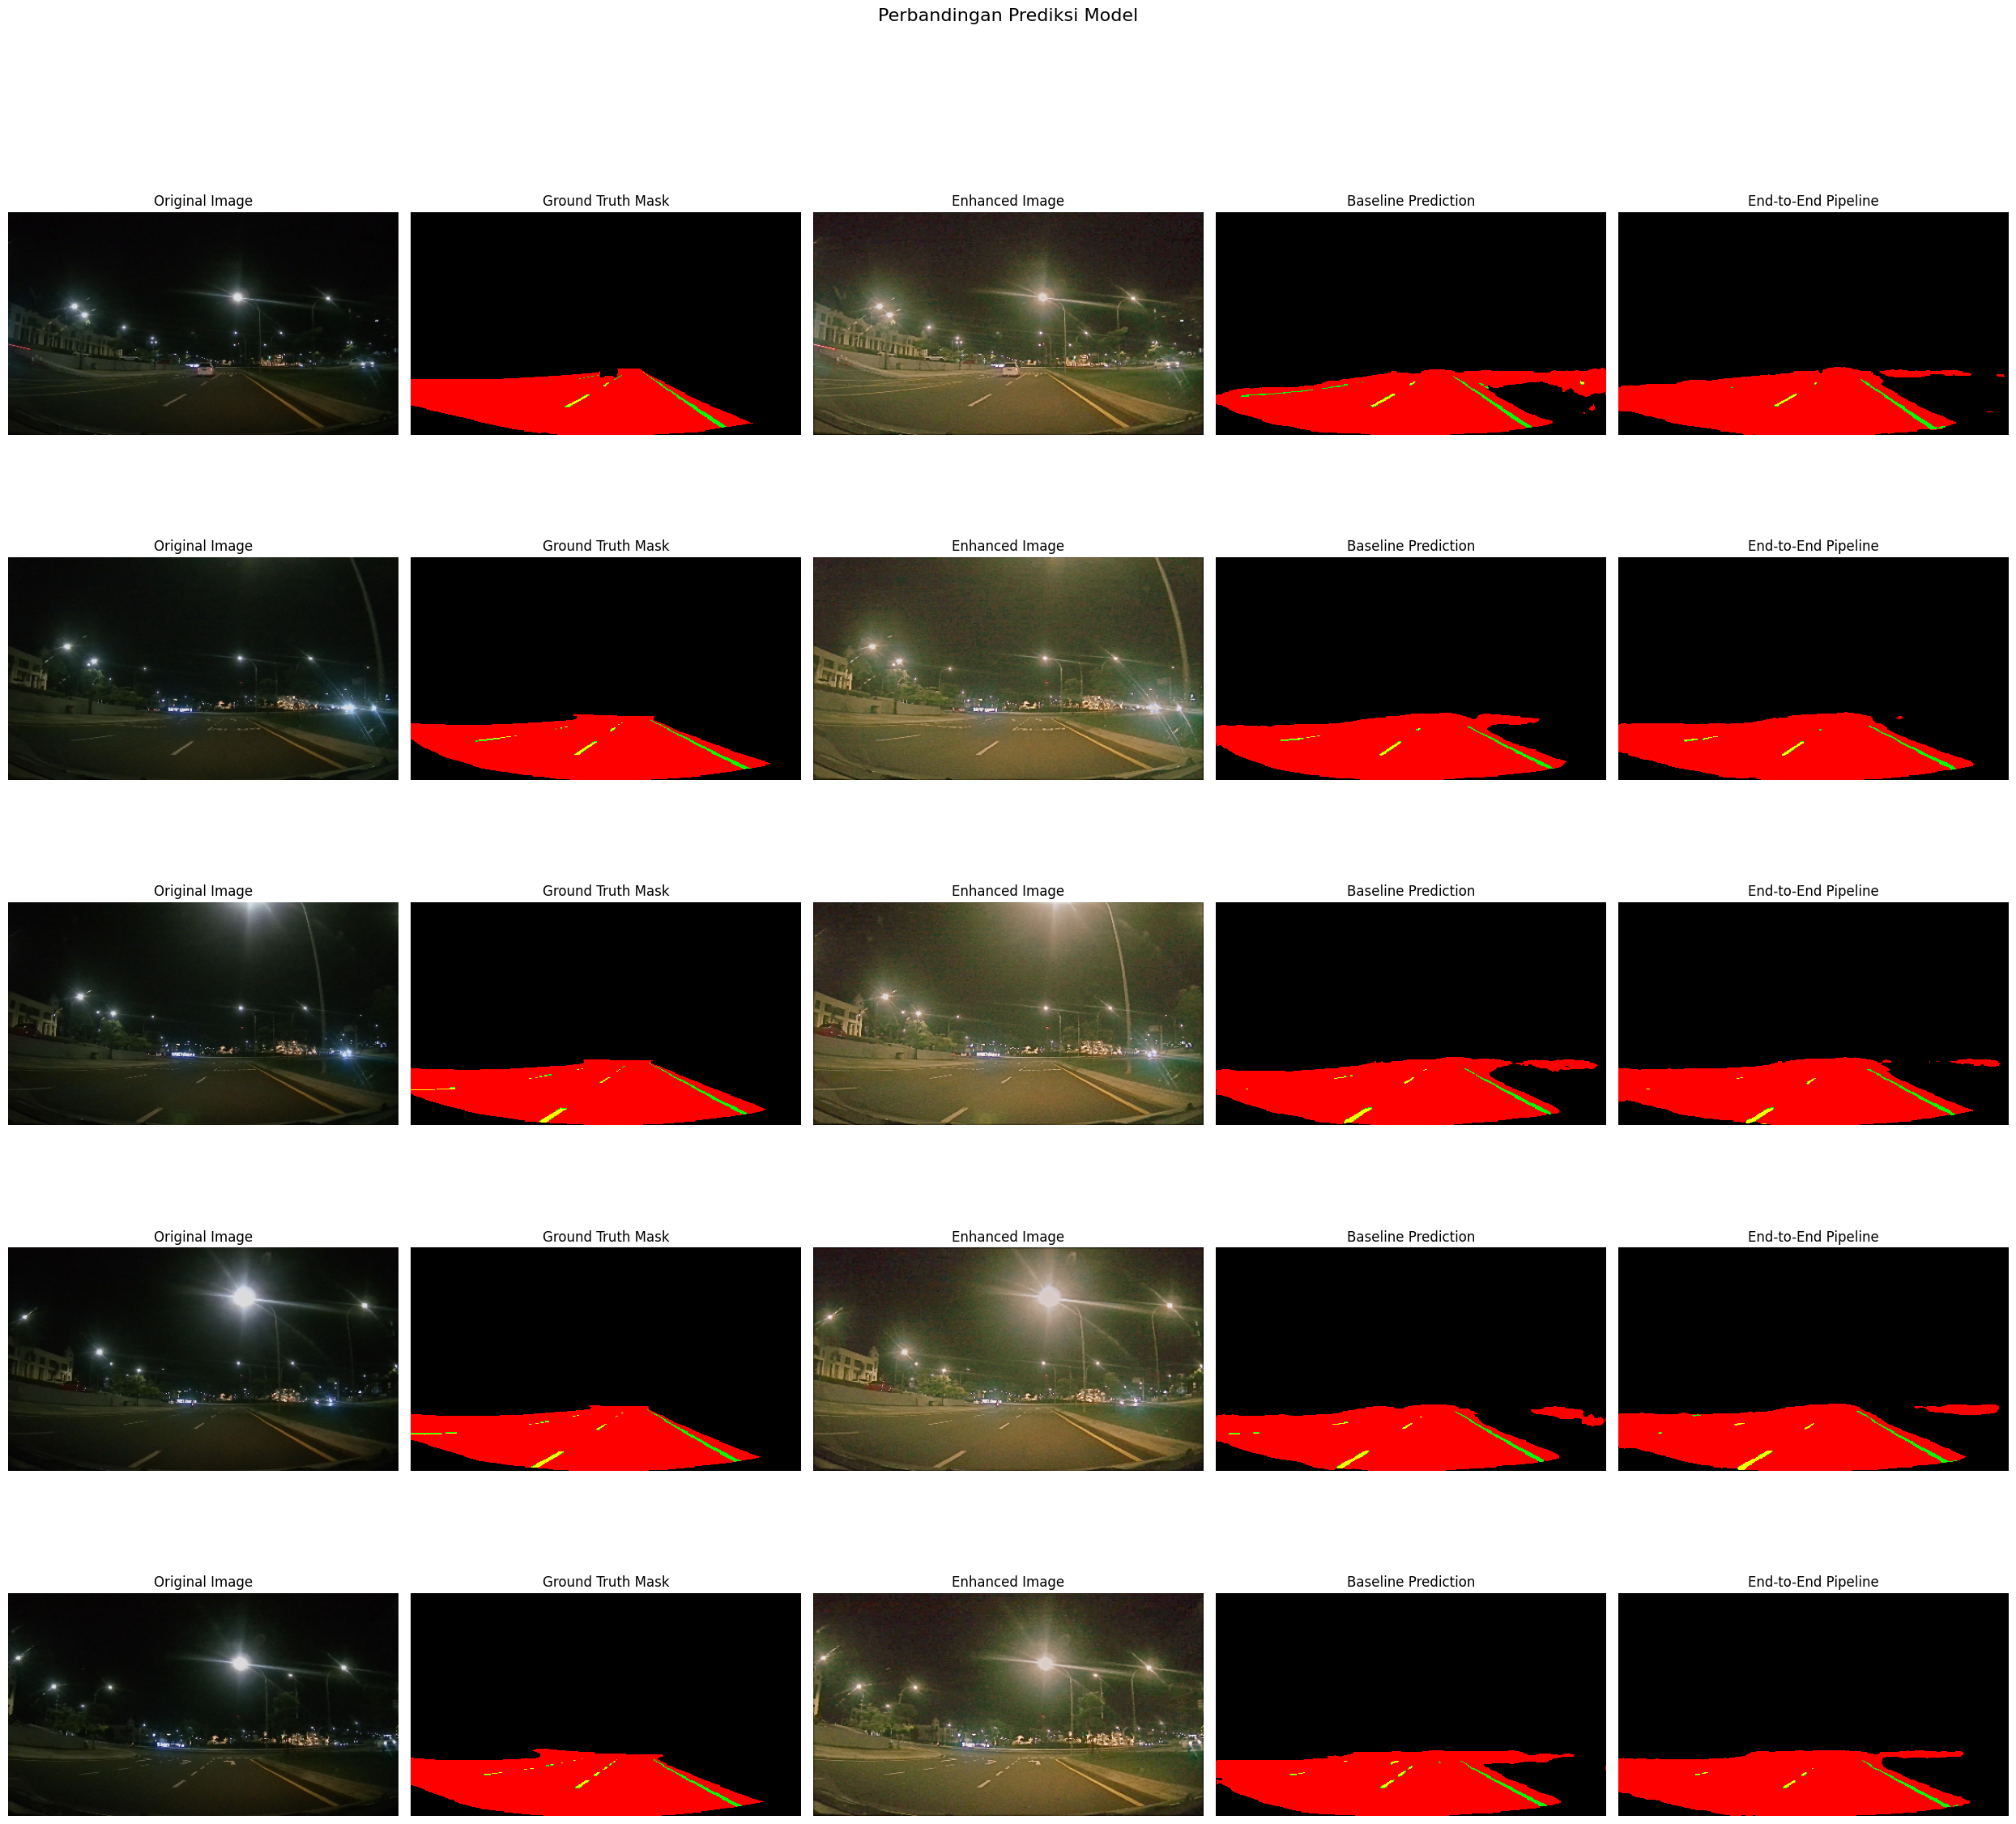

In [16]:
from tabulate import tabulate  # nicer print

results_rows = []

print("\n--- Result Comparison Metric ---")

rows = [
    ["Average", e2e_avg_iou, e2e_avg_dice, base_avg_iou, base_avg_dice]
]

for i in range(1, NUM_CLASSES):
    rows.append([
        CLASS_NAMES[i],
        e2e_iou[i],
        e2e_dice[i],
        base_iou[i],
        base_dice[i],
    ])


# Format table
headers = ["Metric", "End-to-End IoU", "End-to-End Dice", "Baseline IoU", "Baseline Dice"]
print(tabulate(rows, headers=headers, tablefmt="psql", floatfmt=".4f"))

# --- Visualize ---
print("\nVisualizing Comparison...")
custom_cmap = ListedColormap([
    [0, 0, 0],       # Background
    [1, 0, 0],       # Road
    [0, 1, 0],       # lm_solid
    [1, 1, 0],       # lm_dashed
])
visualize_predictions(end_to_end_model, baseline_model, test_dataset, device, num_samples=5, class_names=CLASS_NAMES, custom_cmap=custom_cmap, normalize_transform=normalize_transform)

# Ablation Test

## Smaller Image /2

In [17]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 224

test_transform = A.Compose([A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH), ToTensorV2()])
normalize_transform = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

test_img_paths = sorted(glob.glob(TEST_IMG_PATH))
test_mask_paths = sorted(glob.glob(TEST_MASK_PATH))

test_dataset = CustomDataset(test_img_paths, test_mask_paths, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)


# --- Menjalankan Evaluasi ---
print("\n--- Evalutating End-to-End Model ---")
e2e_smaller_iou, e2e_smaller_dice, e2e_smaller_avg_iou, e2e_smaller_avg_dice = evaluate_model(end_to_end_model, test_loader, device, NUM_CLASSES, is_end_to_end=True, normalize_transform=normalize_transform)

print("\n--- Evaluating Baseline Model ---")
base_smaller_iou, base_smaller_dice, base_smaller_avg_iou, base_smaller_avg_dice = evaluate_model(baseline_model, test_loader, device, NUM_CLASSES, is_end_to_end=False, normalize_transform=normalize_transform)


--- Evalutating End-to-End Model ---


Evaluating End-to-End: 100%|██████████| 8/8 [00:00<00:00, 16.17it/s]



--- Evaluating Baseline Model ---


Evaluating Baseline: 100%|██████████| 8/8 [00:00<00:00, 19.49it/s]



--- Result Comparison Metric ---
+-----------+------------------+-------------------+----------------+-----------------+
| Metric    |   End-to-End IoU |   End-to-End Dice |   Baseline IoU |   Baseline Dice |
|-----------+------------------+-------------------+----------------+-----------------|
| Average   |           0.7064 |            0.8043 |         0.5595 |          0.6688 |
| road      |           0.8039 |            0.8906 |         0.7068 |          0.8272 |
| lm_solid  |           0.5302 |            0.6882 |         0.3453 |          0.5052 |
| lm_dashed |           0.5385 |            0.6625 |         0.2580 |          0.3802 |
+-----------+------------------+-------------------+----------------+-----------------+

Visualizing Comparison...


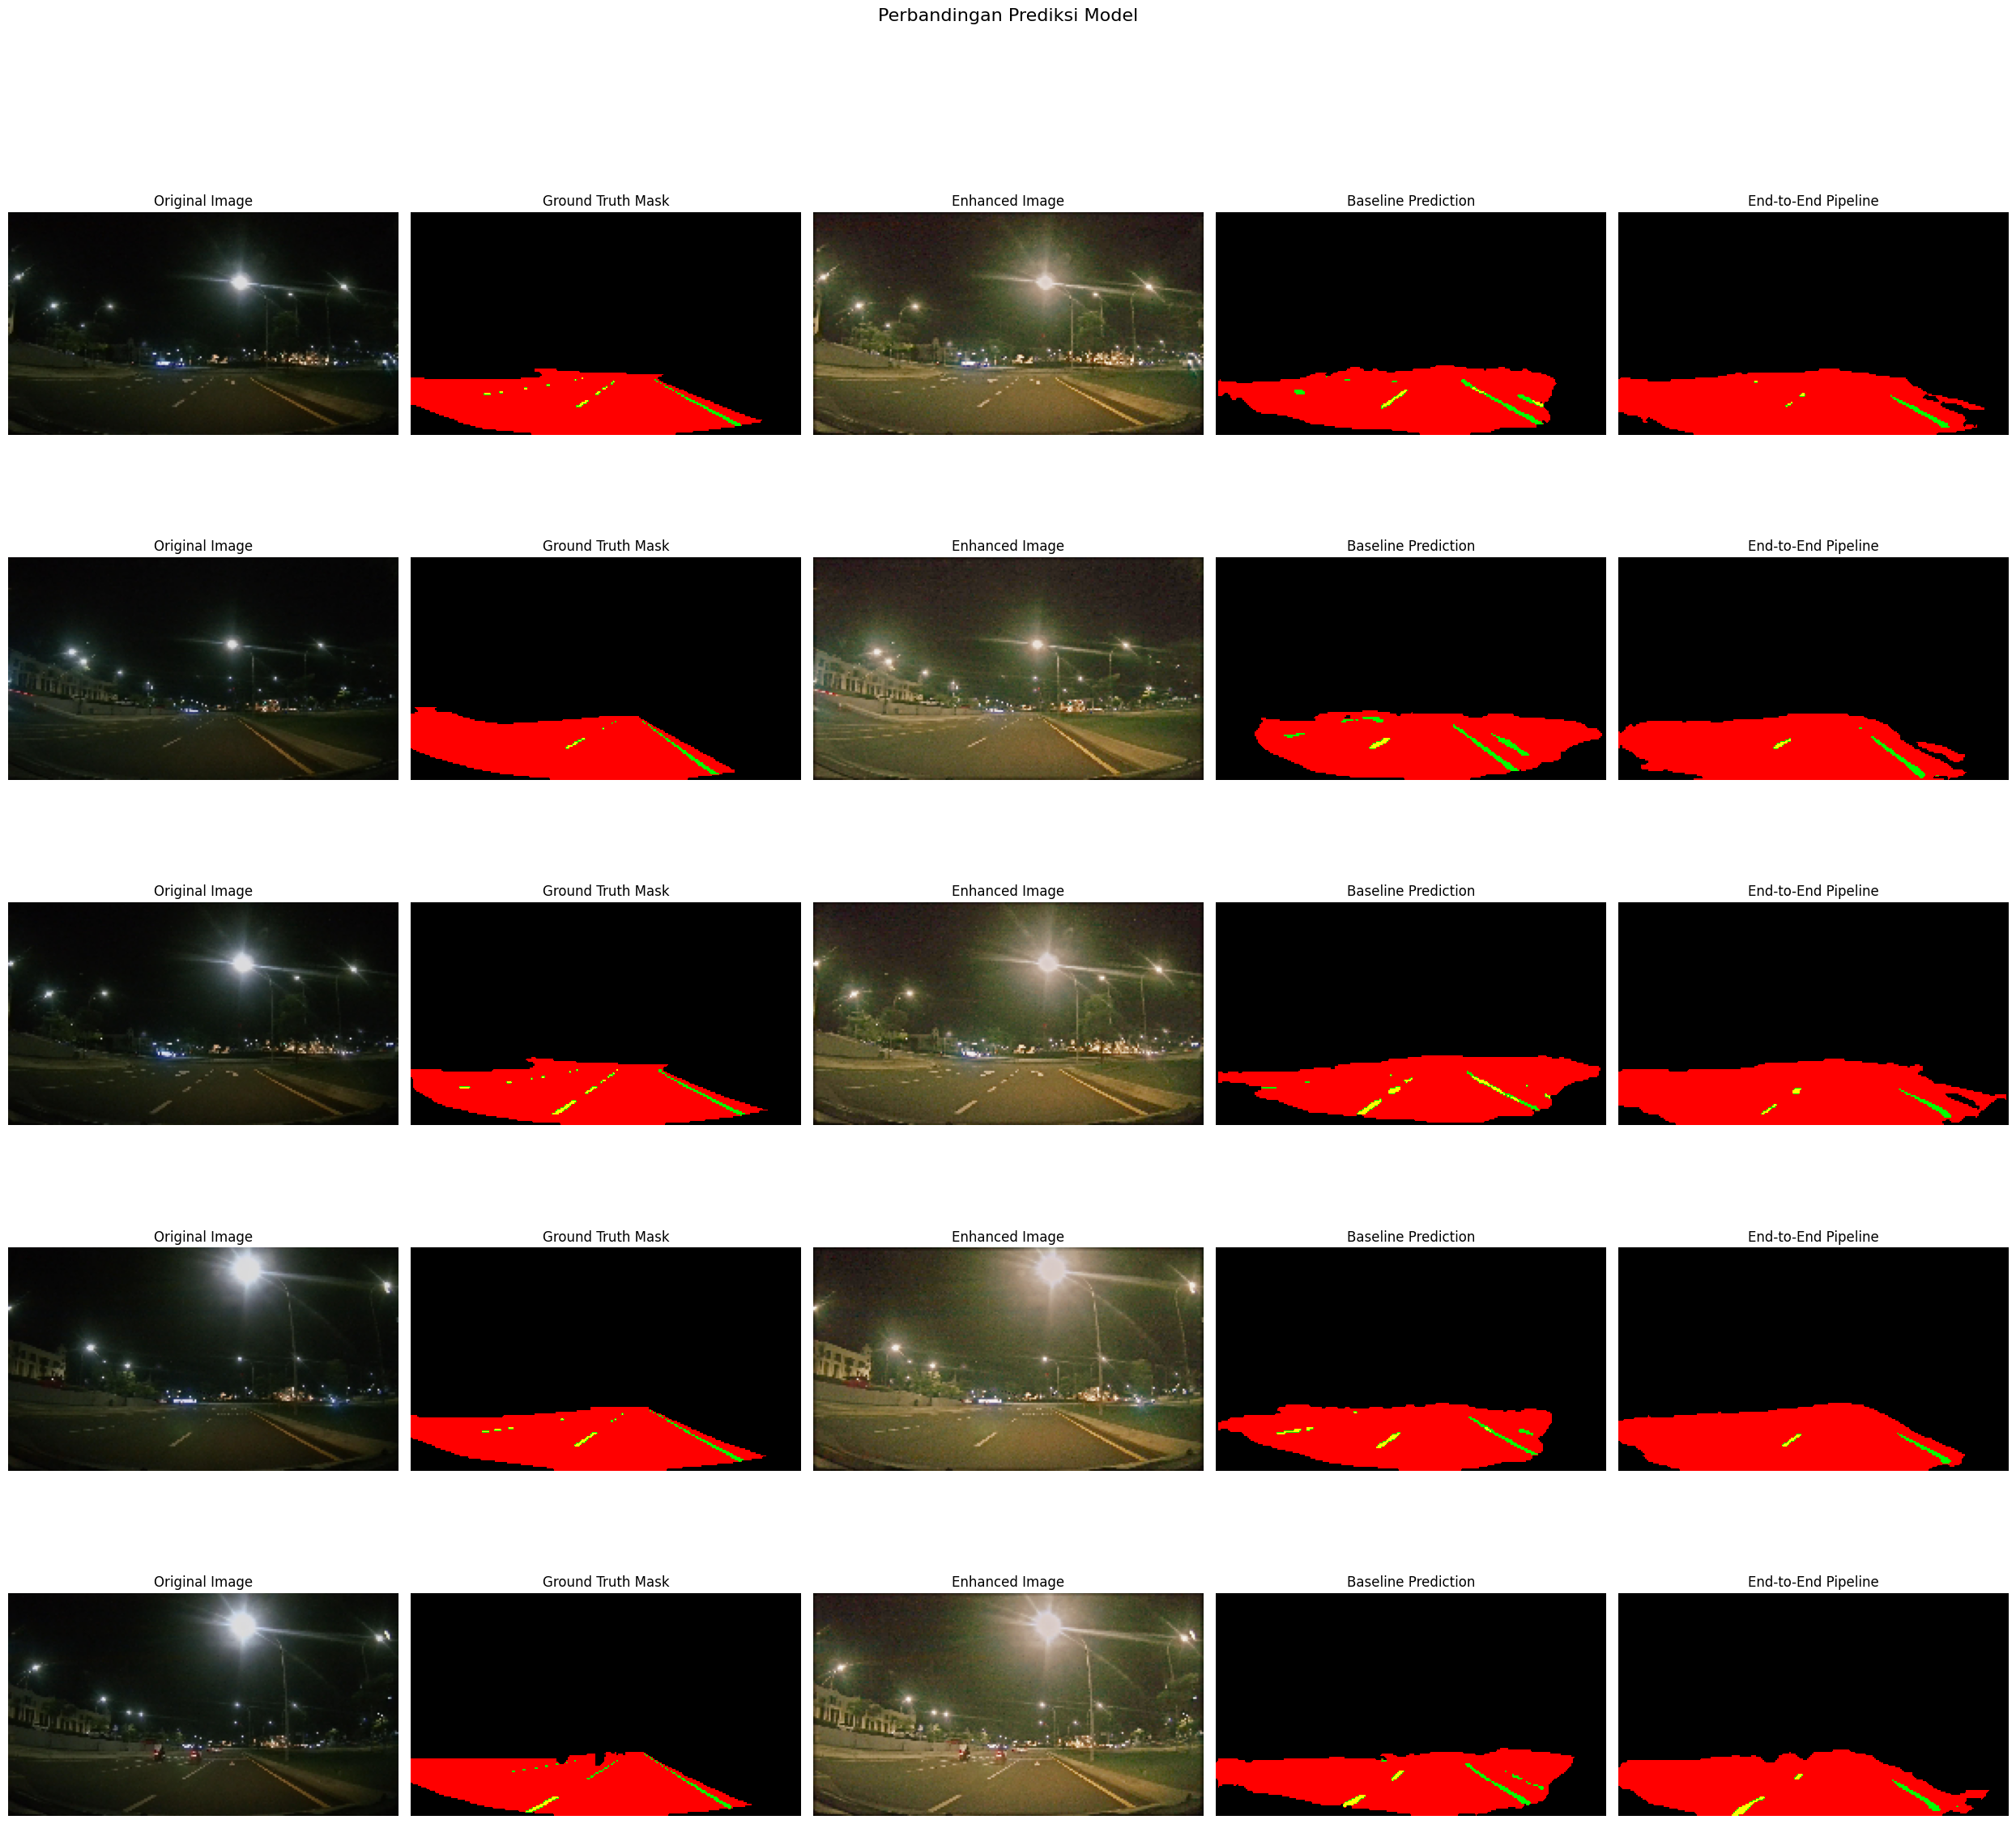

In [18]:
from tabulate import tabulate  # nicer print

results_rows = []

print("\n--- Result Comparison Metric ---")

rows = [
    ["Average", e2e_smaller_avg_iou, e2e_smaller_avg_dice, base_smaller_avg_iou, base_smaller_avg_dice]
]

for i in range(1, NUM_CLASSES):
    rows.append([
        CLASS_NAMES[i],
        e2e_smaller_iou[i],
        e2e_smaller_dice[i],
        base_smaller_iou[i],
        base_smaller_dice[i],
    ])


# Format table
headers = ["Metric", "End-to-End IoU", "End-to-End Dice", "Baseline IoU", "Baseline Dice"]
print(tabulate(rows, headers=headers, tablefmt="psql", floatfmt=".4f"))

# --- Visualize ---
print("\nVisualizing Comparison...")
custom_cmap = ListedColormap([
    [0, 0, 0],       # Background
    [1, 0, 0],       # Road
    [0, 1, 0],       # lm_solid
    [1, 1, 0],       # lm_dashed
])
visualize_predictions(end_to_end_model, baseline_model, test_dataset, device, num_samples=5, class_names=CLASS_NAMES, custom_cmap=custom_cmap, normalize_transform=normalize_transform)

## Even Smaller Image

In [19]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 112

test_transform = A.Compose([A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH), ToTensorV2()])
normalize_transform = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

test_img_paths = sorted(glob.glob(TEST_IMG_PATH))
test_mask_paths = sorted(glob.glob(TEST_MASK_PATH))

test_dataset = CustomDataset(test_img_paths, test_mask_paths, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)


# --- Menjalankan Evaluasi ---
print("\n--- Evalutating End-to-End Model ---")
e2e_even_smaller_iou, e2e_even_smaller_dice, e2e_even_smaller_avg_iou, e2e_even_smaller_avg_dice = evaluate_model(end_to_end_model, test_loader, device, NUM_CLASSES, is_end_to_end=True, normalize_transform=normalize_transform)

print("\n--- Evaluating Baseline Model ---")
base_even_smaller_iou, base_even_smaller_dice, base_even_smaller_avg_iou, base_even_smaller_avg_dice = evaluate_model(baseline_model, test_loader, device, NUM_CLASSES, is_end_to_end=False, normalize_transform=normalize_transform)


--- Evalutating End-to-End Model ---


Evaluating End-to-End: 100%|██████████| 8/8 [00:00<00:00, 18.29it/s]



--- Evaluating Baseline Model ---


Evaluating Baseline: 100%|██████████| 8/8 [00:00<00:00, 19.99it/s]



--- Result Comparison Metric ---
+-----------+------------------+-------------------+----------------+-----------------+
| Metric    |   End-to-End IoU |   End-to-End Dice |   Baseline IoU |   Baseline Dice |
|-----------+------------------+-------------------+----------------+-----------------|
| Average   |           0.4901 |            0.5451 |         0.2587 |          0.2803 |
| road      |           0.7180 |            0.8344 |         0.0092 |          0.0170 |
| lm_solid  |           0.0549 |            0.0920 |         0.0000 |          0.0000 |
| lm_dashed |           0.2559 |            0.2898 |         0.2000 |          0.2000 |
+-----------+------------------+-------------------+----------------+-----------------+

Visualizing Comparison...


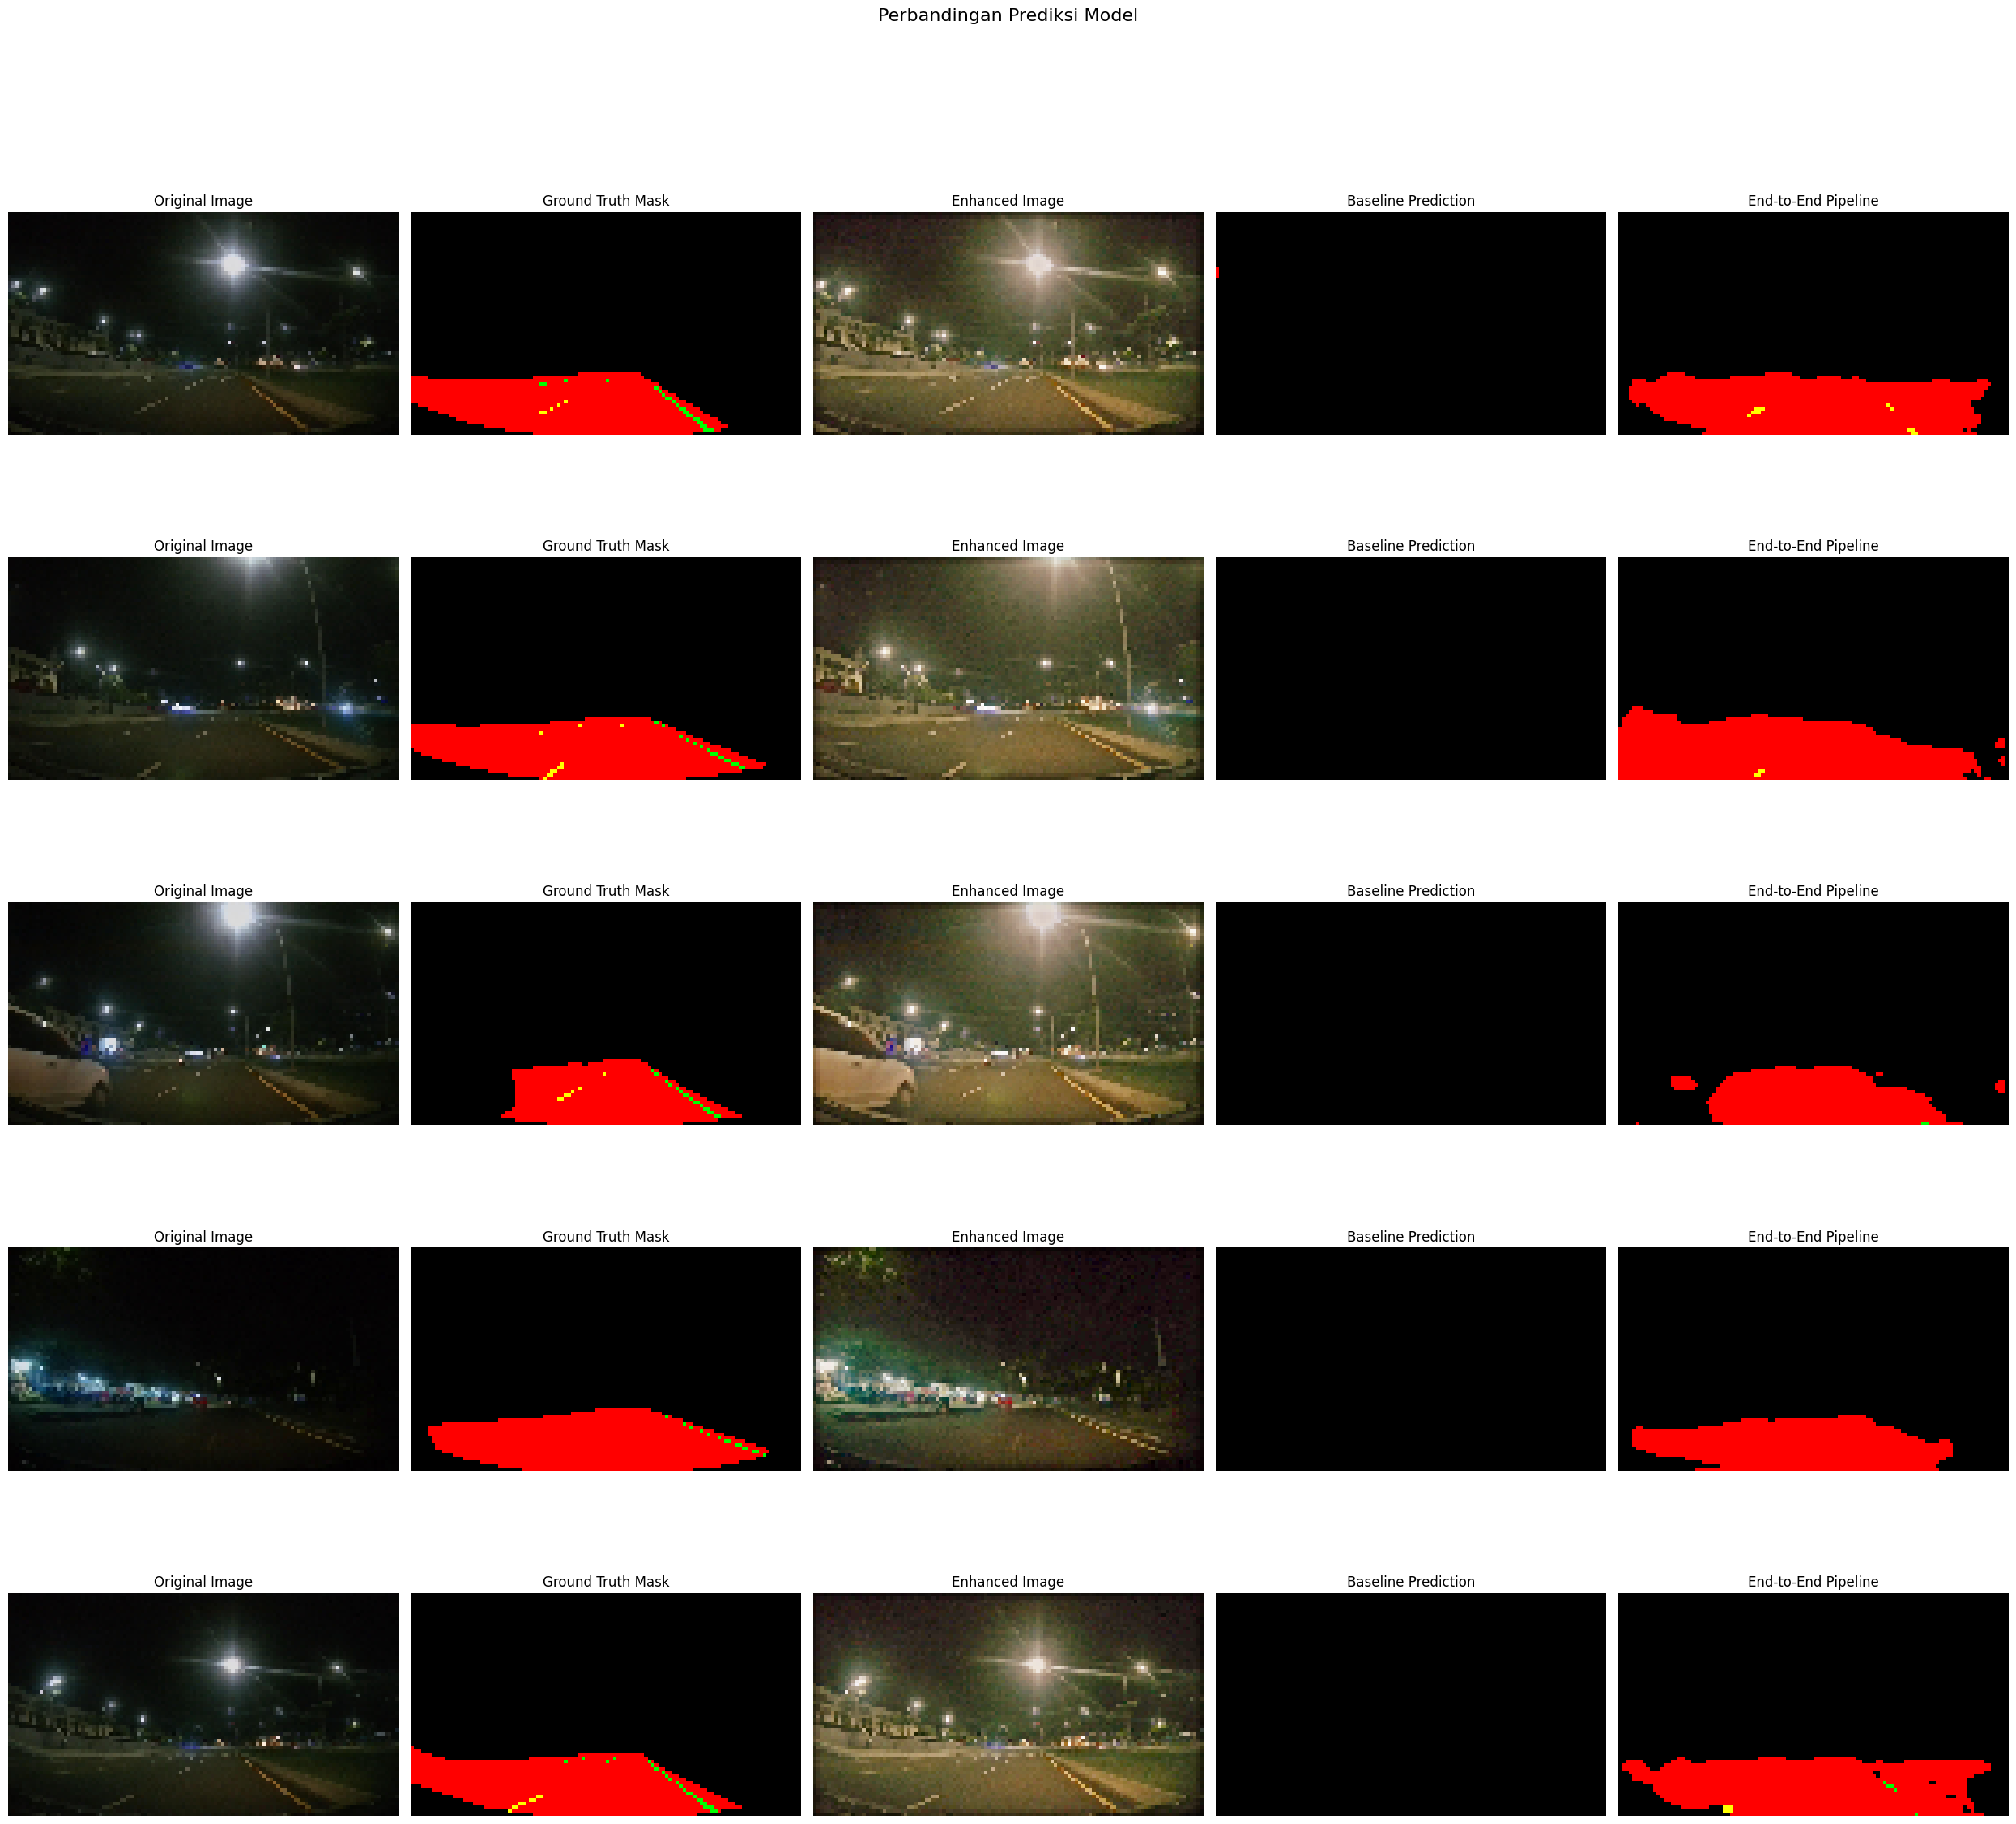

In [20]:
from tabulate import tabulate  # nicer print

results_rows = []

print("\n--- Result Comparison Metric ---")

rows = [
    ["Average", e2e_even_smaller_avg_iou, e2e_even_smaller_avg_dice, base_even_smaller_avg_iou, base_even_smaller_avg_dice]
]

for i in range(1, NUM_CLASSES):
    rows.append([
        CLASS_NAMES[i],
        e2e_even_smaller_iou[i],
        e2e_even_smaller_dice[i],
        base_even_smaller_iou[i],
        base_even_smaller_dice[i],
    ])


# Format table
headers = ["Metric", "End-to-End IoU", "End-to-End Dice", "Baseline IoU", "Baseline Dice"]
print(tabulate(rows, headers=headers, tablefmt="psql", floatfmt=".4f"))

# --- Visualize ---
print("\nVisualizing Comparison...")
custom_cmap = ListedColormap([
    [0, 0, 0],       # Background
    [1, 0, 0],       # Road
    [0, 1, 0],       # lm_solid
    [1, 1, 0],       # lm_dashed
])
visualize_predictions(end_to_end_model, baseline_model, test_dataset, device, num_samples=5, class_names=CLASS_NAMES, custom_cmap=custom_cmap, normalize_transform=normalize_transform)